Work done by :     

DAGHMOURA Haithem & ZAIRI Kais

This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [4]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms


## I-1 - Unregularized algorithms


### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_2.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [5]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x78a65b3e5a50>)

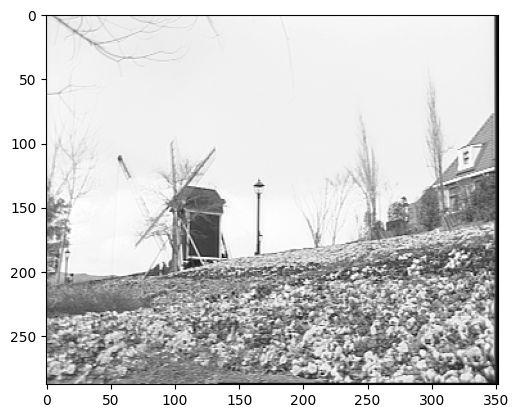

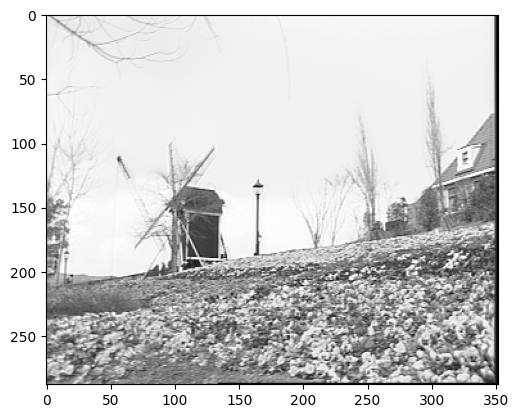

In [6]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [73]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius (in terms of pixels from -8 to 8 x wise and y wise)

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [141]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """


    step = 8
    cont = 4*step

    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)

    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf

    pV=np.zeros(2)

    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)

            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC


    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)

    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]

    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]

    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]

        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]

        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)

    pV = pV.ravel()

    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of cols in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION. Motion vector field
    prediction : TYPE
        DESCRIPTION. The frame that we reconstitue

    """

    extension = search
    # pour tenir compte de fait que le mvt peut se diriger vers le dehors de l'image et éviter les if dans les bords
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect : copies the image in a slightly larger one and filling the boards

    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;   # not necessary to scale

    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    # Non-regularized search
    if lamb == 0.:
        for p in range (0,cur.shape[0],brow) : # for each block in the current image, find the best corresponding block in the reference image
            for q in range (0,cur.shape[1],bcol) :
                # current block selection

                B = cur[p:p+brow,q:q+bcol] # Block
                #print(f"p = {p}, q={q} ,brow= {brow},bcol={bcol}")
                # Initialization:

                costMin = (brow*bcol*255)**2

                Rbest = [0,0]

                # Loop on candidate displacement vectors
                for dcol in  range (q,q+2*search) : # dcol = candidate displacement vector over the columns
                    for drow in range (p,p+2*search) :# rcol = candidate displacement vector over the rows

                        current_block = ref_extended[drow:drow+brow,dcol:dcol+bcol]
                        current_cost = ((current_block-B)**2).sum()
                        if (current_cost <costMin) :# Save the results if they are better than the previous ones
                           #print(f"p = {p}, q={q}, current cost :{current_cost}, cost min : {costMin}, previous {(Rbest[0]-search,Rbest[1]-search)}, new {[drow-search,dcol-search]}")

                           costMin = current_cost
                           #print(f"costMin = {costMin}")
                           Rbest = [drow-search-p,dcol-search-q]
                #print(f"displacement : {Rbest} and costMin = {costMin}")

                mvf[p:p+brow,q:q+bcol,0]= Rbest[0]  # Once the loop is over, save the best row displacement field
                mvf [p:p+brow,q:q+bcol,1]= Rbest[1]# Once the loop is over, save the best column displacement field
                prediction[p:p+brow,q:q+bcol]= ref_extended[p-Rbest[0]+search:p-Rbest[0]+search+brow,q-Rbest[1]+search:q-Rbest[1]+search+bcol]

    else: # Regularized search
        for p in range (0,cur.shape[0],brow) :# for each block in the current image, find the best corresponding block in the reference image
            for q in range (0,cur.shape[1],bcol) :
                # current block selection
                B = cur[p:p+brow,q:q+bcol] # Block

                # Initializations

                costMin =np.inf # largest value possible as init
                Rbest =  [0,0]

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(p,q,brow,bcol,mvf,ref,cur)

                # Loop on candidate vectors
                for dcol  in  range (q,q+2*search) : # dcol = candidate displacement vector over the columns
                    for drow in range (p,p+2*search) : # rcol = candidate displacement vector over the rows

                        #SAD(v)+lambda*error(v)
                        current_block = ref_extended[drow:drow+brow,dcol:dcol+bcol]
                        current_cost = ((current_block-B)**2).sum() +lamb*((pV-np.array([drow-search-p,dcol-search-q]))**2 ).sum() # here, encore the REGULARIZED cost function

                        if (current_cost <costMin) : # Save the results if they are better than the previous ones
                           #print(f"p = {p}, q={q}, current cost :{current_cost}, cost min : {costMin}, previous {(Rbest[0]-search,Rbest[1]-search)}, new {[drow-search,dcol-search]}")

                           costMin = current_cost
                           #print(f"costMin = {costMin}")
                           Rbest = [drow-search-p,dcol-search-q]


                mvf[p:p+brow,q:q+bcol,0]= Rbest[0] # Once the loop is over, save the best row displacement field
                mvf[p:p+brow,q:q+bcol,1]= Rbest[1] # Once the loop is over, save the best column displacement field
                prediction[p:p+brow,q:q+bcol]=ref_extended[p-Rbest[0]+search:p-Rbest[0]+search+brow,q-Rbest[1]+search:q-Rbest[1]+search+bcol]


    mvf = -mvf # For compatibility with standards

    return mvf, prediction

In [89]:
def displayMVF(I,mvf,subsamp):

    row,col = np.shape(I)

    # Subsample dense MVF
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]

    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)

    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)


    return

Let's test out this motion estmation function on an example where we know the motion field vector. Let's say for example that we translate the image by some vector (tx,ty) that we know and test out if it will be found in the image (here tx=ty = 6 <search in order to be able to find the candidate displacement)

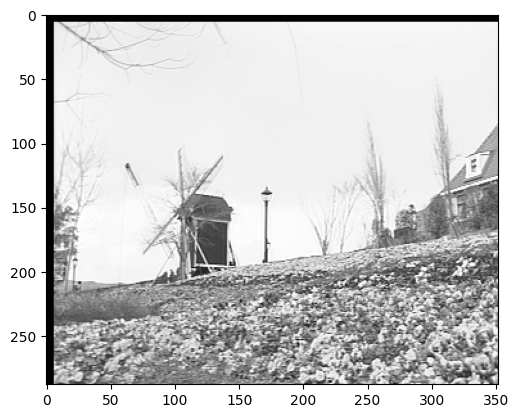

In [90]:
import cv2
import numpy as np

# Read the image
image = im1

# Define the translation matrix
tx = 6  # shift by 50 pixels in the x-direction
ty = 6  # shift by 30 pixels in the y-direction
translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])

# Apply the translation
translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))

# Display the original and translated images
#plt.imshow(image,cmap="gray")
plt.imshow( translated_image,cmap="gray")


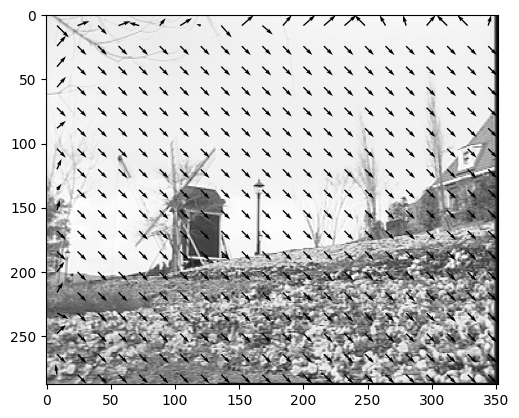

In [91]:
mvf_ssd,prediction =  me_ssd(translated_image, im1, brow, bcol, search_radius)
displayMVF(im1,mvf_ssd,brow)

This is exactly what we expected. expect for the vectors on the upper and left border where the value of the displacement can be anything, all the other values should have an SSD null for (6,6) since the bloxs perfectly match. Now let's continue with the given images

In [92]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?


Answer

Afer coding and displaying the results, we noitice few things :
using the SSD is equivalent to use the mean square error (MSE)
between the current image and the compensated reference. Further more the SSD is very popular, above all for compression applications and this for several reasons. First, the Euclidean distance is a very intuitive and easy to understand metric. Second, by minimizing the SSD, we minimize the mean square error between the current block and the candidate block, that is used as prediction. Hence, this allows an efficient residual coding. In fact, the Motion Compensated (MC) prediction of the current image,  is
often used to measure the quality of the motion estimation. By definition, no
other criterion can provide a better result in this respect (for a given block size and search area). However, the SSD has some drawbacks. First, it is relatively complex, since it requires PQ (in our case brow*bcol) multiplications to be computed (one per each pixel of the block). Second, if some pixels in the image are affected by noise, the square power tends to enhance the associated error, preventing to find the correct motion vector. Third, it does not take into account possible global illumination
variations from one image to the other.

We observe that the field capture the global lateral motion of the sequence and the different apparent velocity of the foreground (the branch of the tree in the upper right and the little variations in the flower field). However this method fails at correctly estimating the movement of very homogenous areas (such as the sky in the upper middle part of the image). In particular SSD seems to produce more outliers such as the vectors that seems to have a larger value and a random direction when compared to others.

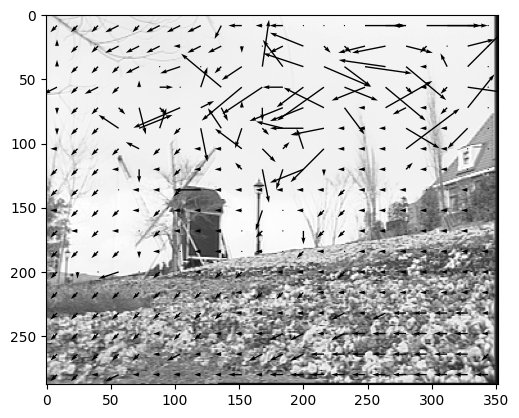

In [93]:
displayMVF(im1,mvf_ssd,brow)

Changing the block size will resul in much danser but more accurate motion vector field. However too small values will lead to much expensive computation. Vise versa, when we increase the block size we will tend to aggregate many pixels and associate one displacement for all of them. This is intersting in the case of homogenious blocks that represent the same object but have rather bad behaviour in the case of borders whose displacement will be outnumberd by the other pixels

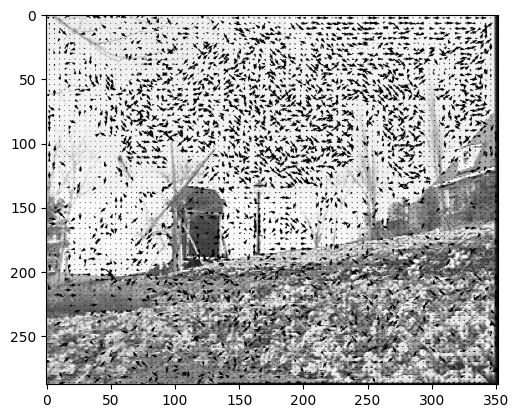

In [94]:
brow = 4
bcol = 4
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)
displayMVF(im1,mvf_ssd,brow)

Changing the search parameter will result in less accuration estimation of the displacement since the true displacement can be out of the search space. Since we by reducing the value we will get less search options. On the other side, increasing that value will result in much more computation since we will covring much larger areas.

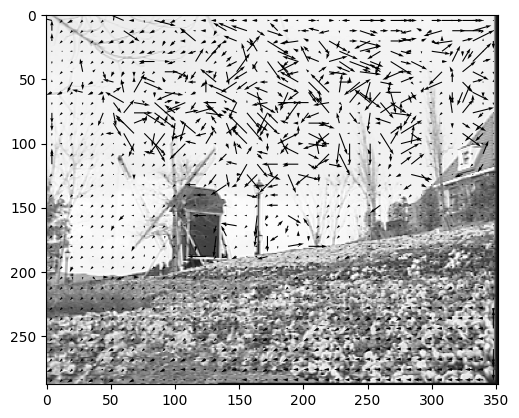

In [95]:
brow = 8
bcol = 8
search = 8
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)
displayMVF(im1,mvf_ssd,brow)

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

In [96]:
def fracMc(ref,mvf,outofbound=20):

    [rows, cols] = np.shape(ref);



    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates

    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement

    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image

    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)

    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points


    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])

    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])


    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)

    motcomp =  griddata(points, values, points_inter,'linear')

    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x78a6464f3070>)

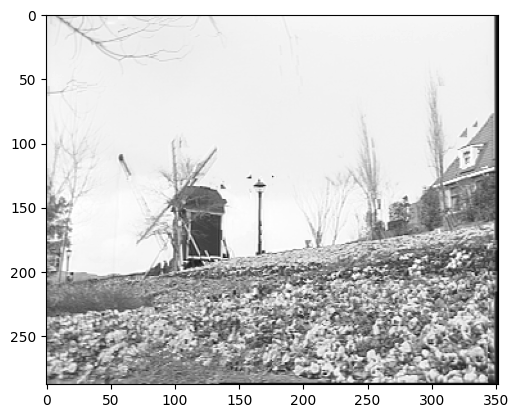

In [97]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

The PSNR is given by the formula : $10×log_{10}(\frac{d^2}{EQM})$

Where d =255 and EQM is the mean quadratic error

In [98]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    d_2=255*255
    EQM = ((im1-im2)**2).sum()/(im1.shape[0]*im1.shape[1])
    psnr = 10*np.log(d_2/EQM)/np.log(10)

    return psnr

In [99]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

16.41206372379801


### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [100]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius (in terms of pixels from -8 to 8 x wise and y wise)

In [172]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)

    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]

    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]

    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]

        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]

        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)

    pV = pV.ravel()

    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """


    step = 8
    cont = 4*step

    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)

    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf

    pV=np.zeros(2)

    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)

            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC


    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """

    extension = search

    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)

    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;

    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

###
    extension = search
    # pour tenir compte de fait que le mvt peut se diriger vers le dehors de l'image et éviter les if dans les bords
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect : copies the image in a slightly larger one and filling the boards

    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;   # not necessary to scale

    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    # Non-regularized search
    if lamb == 0.:
        for p in range (0,cur.shape[0],brow) : # for each block in the current image, find the best corresponding block in the reference image
            for q in range (0,cur.shape[1],bcol) :
                # current block selection

                B = cur[p:p+brow,q:q+bcol] # Block
                #print(f"p = {p}, q={q} ,brow= {brow},bcol={bcol}")
                # Initialization:

                costMin = (brow*bcol*255)**2

                Rbest = [0,0]

                # Loop on candidate displacement vectors
                for dcol in  range (q,q+2*search) : # dcol = candidate displacement vector over the columns
                    for drow in range (p,p+2*search) :# rcol = candidate displacement vector over the rows

                        current_block = ref_extended[drow:drow+brow,dcol:dcol+bcol]
                        current_cost = (np.abs(current_block-B)).sum()
                        if (current_cost <costMin) :# Save the results if they are better than the previous ones
                           #print(f"p = {p}, q={q}, current cost :{current_cost}, cost min : {costMin}, previous {(Rbest[0]-search,Rbest[1]-search)}, new {[drow-search,dcol-search]}")

                           costMin = current_cost
                           #print(f"costMin = {costMin}")
                           Rbest = [drow-search-p,dcol-search-q]
                #print(f"displacement : {Rbest} and costMin = {costMin}")

                mvf[p:p+brow,q:q+brow,0]= Rbest[0]  # Once the loop is over, save the best row displacement field
                mvf [p:p+brow,q:q+brow,1]= Rbest[1]# Once the loop is over, save the best column displacement field
                prediction[p:p+brow,q:q+bcol]= ref_extended[p-Rbest[0]+search:p-Rbest[0]+search+brow,q-Rbest[1]+search:q-Rbest[1]+search+bcol]

###

    else: # Regularized search
        for p in range (0,cur.shape[0],brow) :# for each block in the current image, find the best corresponding block in the reference image
            for q in range (0,cur.shape[1],bcol) :
                # current block selection
                B = cur[p:p+brow,q:q+bcol] # Block

                # Initializations

                costMin =np.inf # largest value possible as init
                Rbest =  [0,0]

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(p,q,brow,bcol,mvf,ref,cur)

                # Loop on candidate vectors
                for dcol  in  range (q,q+2*search) : # dcol = candidate displacement vector over the columns
                    for drow in range (p,p+2*search) : # rcol = candidate displacement vector over the rows

                        #SAD(v)+lambda*error(v)
                        current_block = ref_extended[drow:drow+brow,dcol:dcol+bcol]
                        current_cost = (np.abs(current_block-B)).sum() +lamb*(np.abs(pV-np.array([drow-search-p,dcol-search-q])) ).sum() # here, encore the REGULARIZED cost function

                        if (current_cost <costMin) : # Save the results if they are better than the previous ones
                           #print(f"p = {p}, q={q}, current cost :{current_cost}, cost min : {costMin}, previous {(Rbest[0]-search,Rbest[1]-search)}, new {[drow-search,dcol-search]}")

                           costMin = current_cost
                           #print(f"costMin = {costMin}")
                           Rbest = [drow-search-p,dcol-search-q]


                mvf[p:p+brow,q:q+bcol,0]= Rbest[0] # Once the loop is over, save the best row displacement field
                mvf[p:p+brow,q:q+bcol,1]= Rbest[1] # Once the loop is over, save the best column displacement field
                prediction[p:p+brow,q:q+bcol]=ref_extended[p-Rbest[0]+search:p-Rbest[0]+search+brow,q-Rbest[1]+search:q-Rbest[1]+search+bcol]






    mvf = -mvf # For compatibility with standards

    return mvf, prediction

In [173]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

The SAD is equivalent to the mean absolute error (MAE). In order to compare the
SSD and SAD, we show the motion vector fields obtained using block matching with the SSD (lower) and the SAD (upper) criteria. We also observe that the two fields capture the global lateral motion of the sequence and the different apparent velocity of the foreground and the background. However both methods
fail at correctly estimating the movement of very homogenous areas (such as the
sky in the middle part of the image). In particular SSD seems to produce more outliers such as the vector with origin aprroximatly at (50,160) and pointing to (0,160). This is due to the fact that the SSD relies on the sequare of the difference which may increase the value of noise thus affecting the results.


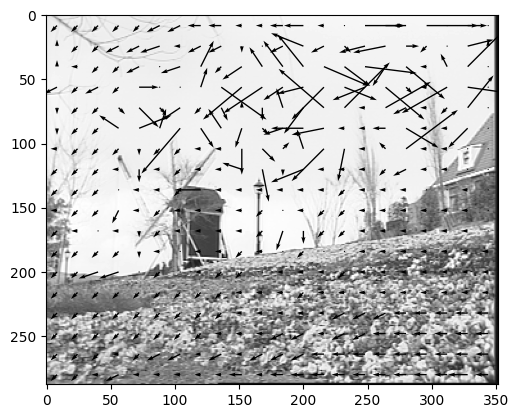

In [174]:
displayMVF(im1,mvf_sad,brow)

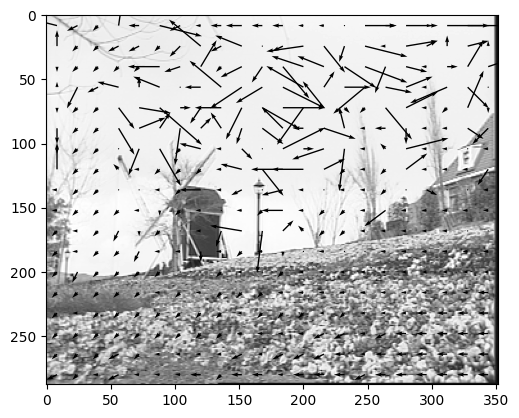

In [111]:
displayMVF(im1,mvf_ssd,brow)

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

The two criteria have very close qualities: the PSNR of the compensated image achieved by minimizing the SSD is only 0.012 dB smaller than the one obtained using SAD. The mvf obtained by the SAD is slightly more regular in our case.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x78a6465b6fe0>)

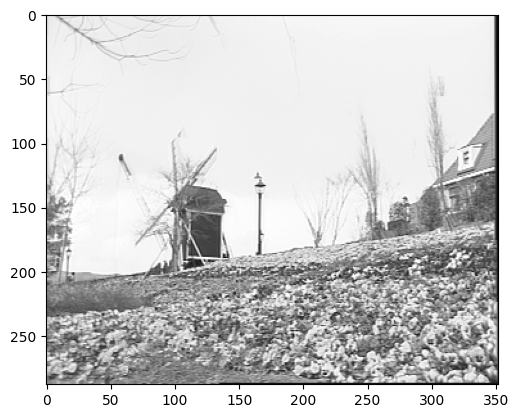

In [112]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [113]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

16.39966244983968


In [115]:
psnr_ssd-psnr_sad

0.012401273958328574

The effect of block size remains the same with SAD criteria. Moreover, we noitice that the mvf ressambles more and more the one of SSD when the block size or the search parameter decreases

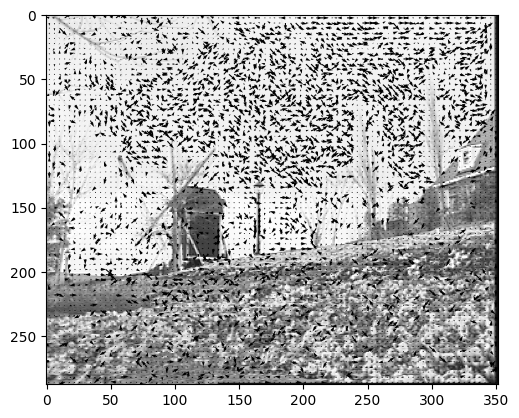

In [66]:
brow,bcol = 4,4
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)
displayMVF(im1,mvf_sad,brow)

## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

By introduting the new regularisation term, we are taking into account the smoothness of our mvf. Thus the candidate displacement having the least SSD won't be necessarily selected but the one who has the best value according to our criteria will be. The lamda value represents the importance of the regularisation term in the compromise between the smoothness of the field and having low SSD.

We noitice that for large value of lamda we get more homogenous mvf where the vectors tends to ressemble thier neighbors. However for small values we get the same result as not having a regularisation term at all and we go back the previous case.

In [143]:
brow, bcol, search_radius = 16,16,8
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius,lamb=10)
displayMVF(im1,mvf_ssd,brow)

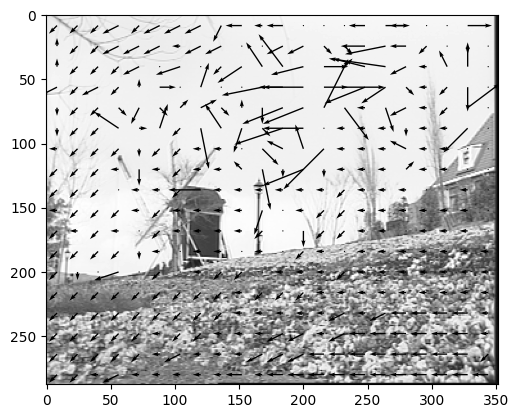

In [144]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius,lamb=0.001)
displayMVF(im1,mvf_ssd,brow)

In [189]:
lamdas = np.linspace(0.0001 ,10000, 15)
psnr_ssds =[]
for lamda in lamdas :
  mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius,lamb=lamda)
  mc_ssd = fracMc(im1,mvf_ssd)
  psnr_ssd = PSNR(im2,mc_ssd)
  psnr_ssds.append(psnr_ssd)

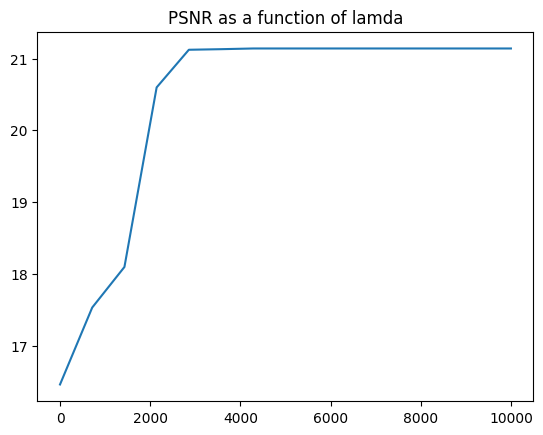

In [190]:
plt.plot(lamdas,psnr_ssds)
plt.title("PSNR as a function of lamda");

In [156]:
print(f"best psnr value is {np.max(psnr_ssds)} obtained for lamda = {lamdas[np.argmax(psnr_ssds)]}")

best psnr value is 21.14010816417288 obtained for lamda = 10000.0


### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

We noitice the same behiour here in the case of SAD with regularisation but with different scale of the value of lamda which is expected since the lamda for SSD is different from that of SAD (not the same order )

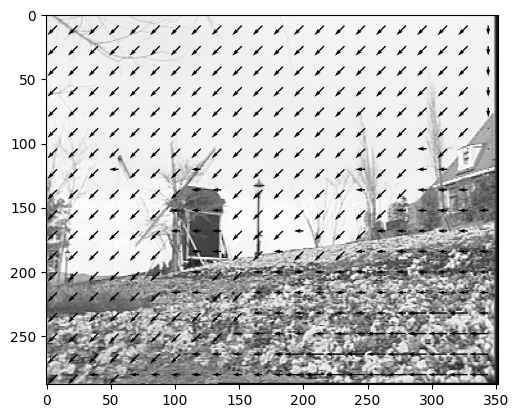

In [182]:
brow, bcol, search_radius = 16,16,8
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius,lamb=0.01)
displayMVF(im1,mvf_sad,brow)

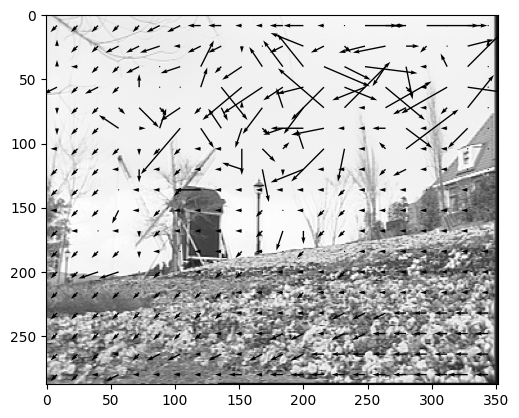

In [183]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius,lamb=0.000001)
displayMVF(im1,mvf_sad,brow)

In [187]:
lamdas = np.linspace(0.00001, 100, num=15)
psnr_sads =[]
for lamda in lamdas :
  mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius,lamb=lamda)
  mc_sad = fracMc(im1,mvf_sad)
  psnr_sad = PSNR(im2,mc_sad)
  psnr_sads.append(psnr_sad)


Text(0.5, 1.0, 'PSNR as a function of lamda')

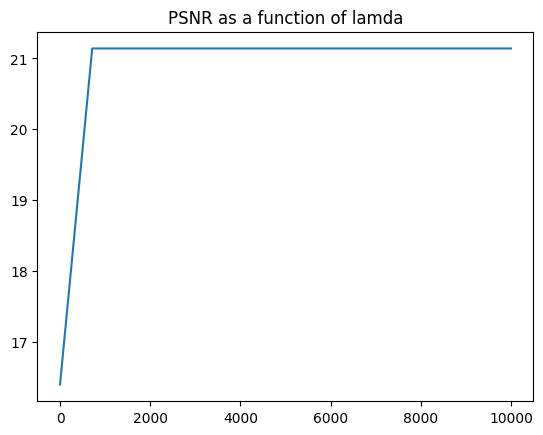

In [191]:
plt.plot(lamdas,psnr_sads)
plt.title("PSNR as a function of lamda")

In [192]:
print(f"best psnr value is {np.max(psnr_sads)} obtained for lamda = {lamdas[np.argmax(psnr_sads)]}")

best psnr value is 21.14010816417288 obtained for lamda = 714.2858071428572


# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [234]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x78a64629d570>)

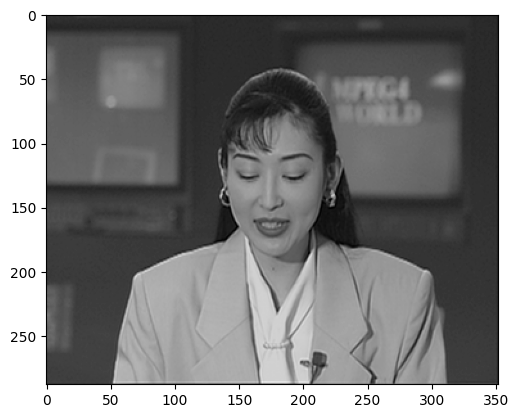

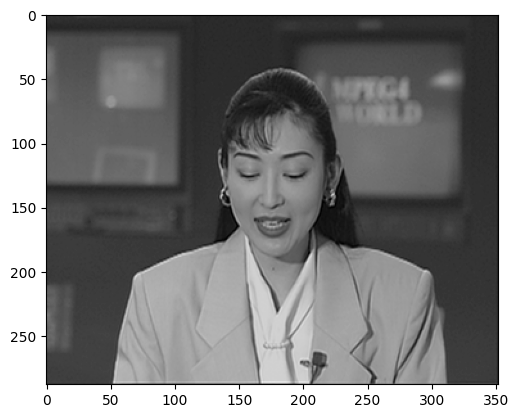

In [235]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [236]:
brow = 16; bcol=16; search_radius =13;

initial_mvf,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

In [237]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337

    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)

    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """

    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)

    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()

    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)

    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])

    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg=convolve2d(u,kernel_1,'same')
        vAvg=convolve2d(v,kernel_1,'same')

        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx*(uAvg*fx+vAvg*fy+ft)/(alpha**2+fx**2+fy**2)
        v = vAvg - fy*(uAvg*fx+vAvg*fy+ft)/(alpha**2+fx**2+fy**2)

    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [238]:
alpha = 100
ite = 100

uInitial = initial_mvf[:,:,0] # Rem: pay attention to the inversion of the order compare to me_ssd.
vInitial = initial_mvf[:,:,1]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

We noitice that the results with HS algorithm are far superioir to those with the block matching algorithm in terms of percesion and accuracy of the motion estimation. we see that in the mvf obtained with HS algorithm that the only the relevant motion of the face are here and the background has a null motion which is pretty the case here.

this is the mvf obtained through HS algorithm :


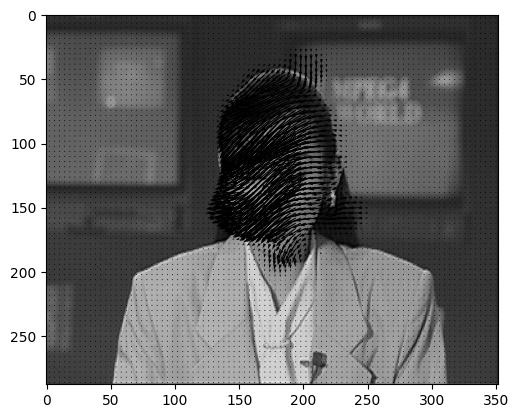

In [239]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
print("this is the mvf obtained through HS algorithm :")
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [240]:
psnr_hs

40.02286403590582

this is the mvf obtained with blockmatching : 


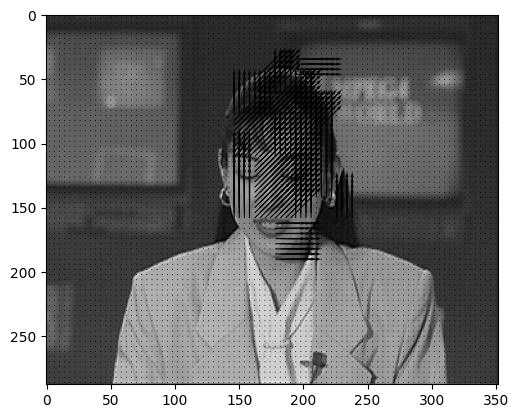

In [241]:
print("this is the mvf obtained with blockmatching : ")
displayMVF(im1,initial_mvf,4)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x78a643626cb0>)

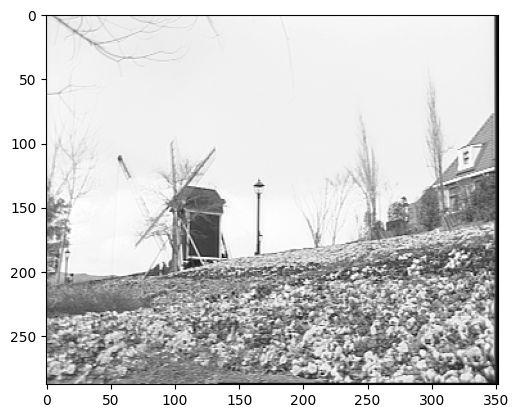

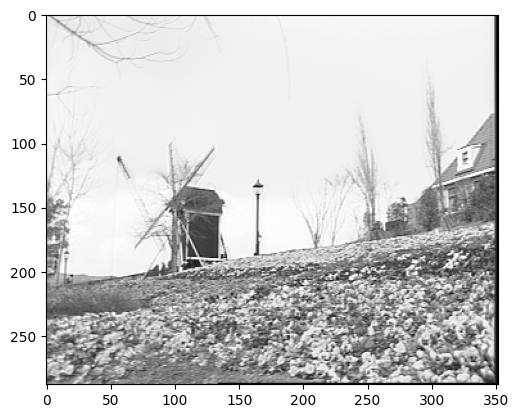

In [242]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

this is the mvf obtained through HS algorithm :


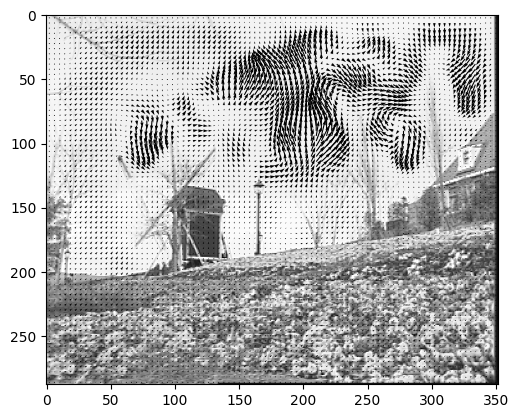

In [246]:
brow = 16; bcol=16; search_radius =13;

initial_mvf,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

alpha = 100
ite = 100

uInitial = initial_mvf[:,:,0] # Rem: pay attention to the inversion of the order compare to me_ssd.
vInitial = initial_mvf[:,:,1]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
print("this is the mvf obtained through HS algorithm :")
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [244]:
psnr_hs

18.724369898516265